In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

## Import Files

In [2]:
current_dir = Path.cwd() / 'effects-of-stadiums'
game_df = pd.read_csv(current_dir / 'cache' / 'games.csv', sep='\t', index_col=0)
team_misc_df = pd.read_csv(current_dir / 'inputs' / 'team_misc.csv', index_col=0)
team_df = pd.read_csv(current_dir / 'inputs' / 'team.csv', index_col=0)
opponent_df = pd.read_csv(current_dir / 'inputs' / 'team_opponent.csv', index_col=0)

## Build Linear Regression for Oppoent FG% and DRtg

In [3]:
data = pd.merge(team_misc_df[["Team", "DRtg"]], opponent_df[["Team", "FG%"]], how="left", on="Team")
X = data["DRtg"]
X = sm.add_constant(X, prepend=False)
Y = data["FG%"]
mod = sm.OLS(Y, X).fit()
DRtgCoefficent = mod.params[0]
constant = mod.params[1]

C:\Users\capd069709\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## Adjust the FG% from actual DRtg to League Average DRtg at 104.6

In [4]:
# Adjust the FG% as if the home team is a team with average DRTG
# Add a new column to store the shooting % difference
team_misc_df['avgDiff'] = 0
leagueAvgDRTG = data["DRtg"].mean()

def adjustFG(DRtg, fg, constant, DRtgCoefficent, leagueAvgDRTG):
    adjFG = (DRtgCoefficent * DRtg + constant) - (DRtgCoefficent * leagueAvgDRTG + constant)
    return (fg - adjFG)

for homeTeamName in game_df['Home Team'].unique():
    homeTeamDiff = np.array([])
    df = game_df.loc[game_df['Home Team'] == homeTeamName]
    
    for awayTeamName in df['Away Team'].unique():
        df2 = df.loc[df['Away Team'] == awayTeamName]
        # This stores the average shooting percentage the away team
        # shoots at the home team stadium
        awayFG = df2['Away Shooting Percentage'].mean()
        
        # Adjust the FG% of away team against the defensive abilities
        # of the home team as if it is playing a league average team
        homeTeamStats = team_misc_df.loc[team_misc_df['Name'] == homeTeamName]
        DRtg = float(homeTeamStats['DRtg'])
        adjawayFG = adjustFG(DRtg, awayFG, constant, DRtgCoefficent, leagueAvgDRTG)
        
        awayTeamStats = team_df.loc[team_df['Name'] == awayTeamName]
        # This stores the average shooting percentage of the away team
        awayAverageFG = float(awayTeamStats['FG%'])
        
        # This stores the difference between adjusted average shooting percentage
        # and the shooting percentage at the stadium 
        # +ve means the team shoots better than average
        # -ve means the team shoots worse than average
        diff = adjawayFG - awayAverageFG
        homeTeamDiff = np.append(homeTeamDiff, diff)
    
    avgDiff = np.mean(homeTeamDiff)
        
    # Add the avgDiff into the appropriate place in the team_misc_df
    team_misc_df.loc[team_misc_df['Name'] == homeTeamName, 'avgDiff'] = avgDiff
                      
team_misc_df.to_csv(current_dir / 'outputs' / 'analysis.csv', sep=',')

C:\Users\capd069709\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


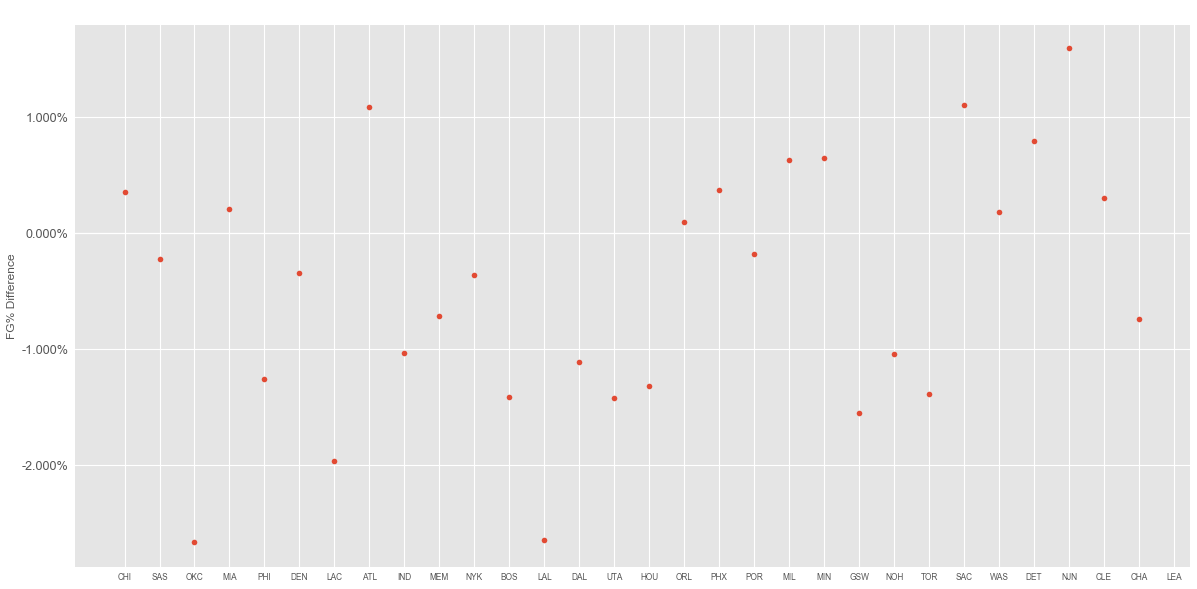

In [5]:
# using ggplot styles
plt.style.use('ggplot')

# reading the analysis dataframe from csv
analysisDf = pd.read_csv(current_dir / 'cache' / 'analysis.csv', index_col=0)
teams = analysisDf['Name']
diff = analysisDf['avgDiff']

# plot
figure = plt.figure(figsize=(20,10))
plt.plot(range(len(diff)), diff*100, 'o')
plt.axhline(y=0)
plt.xticks(range(len(diff)), teams, size='small')
plt.rcParams['xtick.major.pad'] = 6
            
# yticks
locs, labels = plt.yticks()
plt.ylabel('FG% Difference')
plt.title('Effects of Stadiums')
            
# moving the x-axis to the center
ax = figure.add_subplot(1,1,1)

def pct(x, pos):
    return "{0:.3f}%".format(float(x))
ax.yaxis.set_major_formatter(plt.FuncFormatter(pct))

plt.savefig(current_dir / 'outputs' / 'results.png')